In [1]:
import sys 
from pathlib import Path
import torch
import os
import dill
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
from pathlib import Path
import cv2
import time

sys.path.append("/home/franka_deoxys/diffusion_policy")
from diffusion_policy.workspace.base_workspace import BaseWorkspace
from diffusion_policy.model.common.rotation_transformer import RotationTransformer
from diffusion_policy.common.pytorch_util import dict_apply
from diffusion_policy.workspace.train_diffusion_unet_hybrid_workspace import TrainDiffusionUnetHybridWorkspace


sys.path.append("/home/franka_deoxys/deoxys_control/deoxys")
from deoxys import config_root
from deoxys.franka_interface import FrankaInterface
from deoxys.utils import  YamlConfig
from deoxys.utils.config_utils import robot_config_parse_args
from deoxys.utils.input_utils import input2action
from deoxys.utils.io_devices import SpaceMouse
from deoxys.utils.log_utils import get_deoxys_example_logger
from deoxys.experimental.motion_utils import follow_joint_traj, reset_joints_to

sys.path.append("/home/franka_deoxys/deoxys_vision")
from deoxys_vision.networking.camera_redis_interface import CameraRedisSubInterface
from deoxys_vision.utils.camera_utils import assert_camera_ref_convention, get_camera_info


from util_eval import RobotStateRawObsDictGenerator, FrameStackForTrans

np.set_printoptions(precision=3, suppress=True)

logger = get_deoxys_example_logger()

/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
args = robot_config_parse_args()
robot_interface = FrankaInterface(os.path.join(config_root, args.interface_cfg))
controller_cfg = YamlConfig(
    os.path.join(config_root, args.controller_cfg)
).as_easydict()
controller_type = args.controller_type

# spacemouse = SpaceMouse(vendor_id=9583, product_id=50734) 
#old spacemoue not wireless
spacemouse = SpaceMouse(vendor_id=9583, product_id=50770)
spacemouse.start_control()
raw_obs_dict_generator = RobotStateRawObsDictGenerator()

Opening SpaceMouse device
Manufacturer: 3Dconnexion
Product: 3Dconnexion Universal Receiver

Control                       	Command
Right button                  	reset simulation
Left button (hold)            	close gripper
Move mouse laterally          	move arm horizontally in x-y plane
Move mouse vertically         	move arm vertically
Twist mouse about an axis     	rotate arm about a corresponding axis
ESC                           	quit



In [4]:
def set_gripper(open=True):
    d=-1. if open else 1.0
    action_close=np.array([ 0.,  0., -0.,  0.,  0., -0., d])
    robot_interface.control(
        controller_type=controller_type,
        action=action_close,
        controller_cfg=controller_cfg,
    )

### reset robot position (no need to do it from terminal)

In [5]:
# copied from reset_robot_joints.py
# Golden resetting joints
reset_joint_positions = [
        0.037,-1.655,0.099,-2.993,-0.074,2.321,0.921]

# reset_joint_positions= [0.03492503,-1.64946574,0.09731048,-2.99831706,
#                         0.06887073,2.31927159,0.91575789]

In [7]:
if robot_interface._state_buffer:
    last_state = robot_interface._state_buffer[-1]
else:
    print("The state buffer is empty.")
    

### getting lowdim obs + camera obs

In [8]:
camera_ids = [0, 1]
# camera_ids = [0]
cr_interfaces = {}

use_depth = False
for camera_id in camera_ids:
    camera_ref=f"rs_{camera_id}"
    assert_camera_ref_convention(camera_ref)
    camera_info = get_camera_info(camera_ref)
    print('---------****-----------')
    print(camera_info)
    print('--------------------------')
    # camera_info=  {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
# 

    cr_interface = CameraRedisSubInterface(camera_info=camera_info, use_depth=use_depth, redis_host='127.0.0.1')
    cr_interface.start()
    cr_interfaces[camera_id] = cr_interface

---------****-----------
{'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'} True False
---------****-----------
{'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'} True False


In [9]:
def get_imgs(use_depth=False):
    data = {}
    for camera_id in camera_ids:
        img_info = cr_interfaces[camera_id].get_img_info()
        data[f"camera_{camera_id}"]=img_info

        imgs = cr_interfaces[camera_id].get_img()
    
        color_img = imgs["color"][..., ::-1]
        
        # color_img = cv2.resize(color_img, (128, 128))  
        # depth_img = cv2.resize(depth_img, (128, 128))
        
        # color_img = cv2.resize(color_img, ) 


        # color_img = cv2.resize(color_img, (224, 224), fx=0.5, fy=0.5)

        color_img = cv2.resize(color_img, None, fx=0.5, fy=0.5)

        data[f"camera_{camera_id}_color"]=color_img

        if use_depth:
            depth_img = imgs["depth"]
            depth_img = cv2.resize(depth_img, (224, 224)) 
            data[f"camera_{camera_id}_depth"]=depth_img
    return data

In [10]:
data = get_imgs()
print('keys: ', data.keys())

img_wrist = data['camera_0_color']
img_front = data['camera_1_color']

agentview_rgb=img_wrist 
eye_in_hand_rgb=img_front
agentview_rgb.shape, eye_in_hand_rgb.shape

keys:  dict_keys(['camera_0', 'camera_0_color', 'camera_1', 'camera_1_color'])


((240, 320, 3), (240, 320, 3))

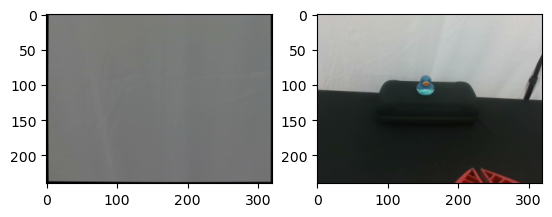

In [11]:
plt.subplot(121)
plt.imshow(agentview_rgb[:,:,::-1])
plt.subplot(122)
plt.imshow(eye_in_hand_rgb[:,:,::-1])

In [12]:
def get_current_obs(robot_interface):
    last_state = robot_interface._state_buffer[-1]
    # print(last_state)
    last_gripper_state = robot_interface._gripper_state_buffer[-1]
    
    obs_dict = raw_obs_dict_generator.get_raw_obs_dict(
    {"last_state": last_state, "last_gripper_state": last_gripper_state})
    # obs_dict={} #rgb only 

    data = get_imgs()
    img_wrist = data['camera_0_color']
    img_front = data['camera_1_color']

    agentview_rgb=img_wrist
    eye_in_hand_rgb=img_front
    # agentview_rgb=cv2.resize(img_wrist, (120, 120))  
    # eye_in_hand_rgb=cv2.resize(img_front, (120, 120)) 

    # agentview_rgb.shape, eye_in_hand_rgb.shape

    # obs_dict['agentview_rgb']=agentview_rgb.transpose(2, 1, 0)
    obs_dict['eye_in_hand_rgb']=eye_in_hand_rgb.transpose(2, 1, 0)
    return obs_dict

In [26]:
obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys():
    obs_dict[key]=obs_dict[key][None]
    print(key, obs_dict[key].shape)

ee_states (1, 16)
joint_states (1, 7)
gripper_states (1, 1)
eye_in_hand_rgb (1, 3, 320, 240)


### Now load dp policy

In [25]:
checkpoint = '/home/franka_deoxys/riad/diffusion_policy/duck_train/epoch_400_20250227_225952.ckpt'
payload = torch.load(open(checkpoint, 'rb'), pickle_module=dill)
cfg = payload['cfg'] 
workspace = TrainDiffusionUnetHybridWorkspace(cfg, output_dir=None)
workspace: BaseWorkspace
workspace.load_payload(payload, exclude_keys=None, include_keys=None)


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['joint_states', 'ee_states', 'gripper_states']
using obs modality: rgb with keys: ['eye_in_hand_rgb']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Diffusion params: 2.528022e+08
Vision params: 1.119709e+07


In [27]:
# get policy from workspace
policy = workspace.model
if cfg.training.use_ema:
    policy = workspace.ema_model

device = torch.device(device)
policy.to(device)
policy.eval()
pass 

In [28]:
rotation_transformer = RotationTransformer('axis_angle', 'rotation_6d')

def undo_transform_action( action):
    raw_shape = action.shape
    if raw_shape[-1] == 20:
        # dual arm
        action = action.reshape(-1,2,10)

    d_rot = action.shape[-1] - 4
    pos = action[...,:3]
    rot = action[...,3:3+d_rot]
    gripper = action[...,[-1]]
    rot = rotation_transformer.inverse(rot)
    uaction = np.concatenate([
        pos, rot, gripper
    ], axis=-1)

    if raw_shape[-1] == 20:
        # dual arm
        uaction = uaction.reshape(*raw_shape[:-1], 14)

    return uaction


### test prediction on a obs

In [29]:
def predict_action(obs):
    """ 
    obs: 2x...
    """
    np_obs_dict = {key:obs[key] for key in keys_select}
    obs_dict = dict_apply(np_obs_dict, 
        lambda x: torch.from_numpy(x).to(
            device=device))

    for key in obs_dict.keys():
        obs_dict[key]=obs_dict[key].unsqueeze(0) 

    
    with torch.no_grad():
        action_dict = policy.predict_action(obs_dict)

    # device_transfer
    np_action_dict = dict_apply(action_dict, lambda x: x.detach().to('cpu').numpy())


    # step env
    env_action =  np_action_dict['action']
    env_action = undo_transform_action(env_action)

    env_action=env_action.squeeze()
    return env_action

In [30]:
framestacker=FrameStackForTrans(2)
keys_select = [ 'joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']

In [31]:
obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys(): 
    print(key, obs_dict[key].shape)

ee_states (16,)
joint_states (7,)
gripper_states (1,)
eye_in_hand_rgb (3, 320, 240)


In [32]:
keys_select = [ 'joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']

In [33]:
framestacker=FrameStackForTrans(2) 
policy.reset()

obs_dict=get_current_obs(robot_interface)
obs = framestacker.reset(obs_dict)

In [34]:
obs_dict=get_current_obs(robot_interface)
obs = framestacker.add_new_obs(obs_dict)
action_pred=predict_action(obs)
action_pred

array([[ 0.48 ,  0.005,  0.162,  0.003,  0.03 , -0.008, -1.   ],
       [ 0.478,  0.006,  0.175,  0.002,  0.024, -0.008, -0.998],
       [ 0.499,  0.012,  0.151,  0.002,  0.017, -0.006, -0.998],
       [ 0.499,  0.012,  0.157,  0.001,  0.015, -0.008, -1.   ],
       [ 0.514,  0.012,  0.127,  0.002,  0.01 , -0.008, -0.999],
       [ 0.538,  0.02 ,  0.148, -0.002,  0.011, -0.008, -0.998],
       [ 0.534,  0.013,  0.118,  0.001,  0.005, -0.01 , -0.999],
       [ 0.545,  0.019,  0.119, -0.003,  0.004, -0.009, -0.999]],
      dtype=float32)

Safety Check

In [35]:
import time
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
from scipy.spatial.transform import Rotation as R


###############################################################################
# 1) (Unchanged) Forward Kinematics & Safe-Set Utilities
###############################################################################
def dh_transform(a, alpha, d, theta):
    return np.array([
        [ np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha),  a*np.cos(theta)],
        [ np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha),  a*np.sin(theta)],
        [ 0,              np.sin(alpha),                np.cos(alpha),                d              ],
        [ 0,              0,                            0,                            1              ]
    ], dtype=float)


def franka_forward_kinematics(joint_angles):
    """
    Convert 7 Franka joint angles -> 4x4 transform in the base frame.
    (Same code as used in your safe-set generation.)
    """
    q1, q2, q3, q4, q5, q6, q7 = joint_angles
    T1 = dh_transform(a=0,       alpha=0,         d=0.333,   theta=q1)
    T2 = dh_transform(a=0,       alpha=-np.pi/2,  d=0,       theta=q2)
    T3 = dh_transform(a=0,       alpha=np.pi/2,   d=0.316,   theta=q3)
    T4 = dh_transform(a=0.0825,  alpha=np.pi/2,   d=0,       theta=q4)
    T5 = dh_transform(a=-0.0825, alpha=-np.pi/2,  d=0.384,   theta=q5)
    T6 = dh_transform(a=0,       alpha=np.pi/2,   d=0,       theta=q6)
    T7 = dh_transform(a=0.088,   alpha=np.pi/2,   d=0,       theta=q7)
    # Flange offset
    T_flange = dh_transform(a=0, alpha=0, d=0.107, theta=0)
    return T1 @ T2 @ T3 @ T4 @ T5 @ T6 @ T7 @ T_flange

def joint_angles_to_end_effector_pose(joint_angles):
    """
    Convert 7 Franka joint angles -> [x, y, z, qx, qy, qz, qw].
    (Exactly the same as in your safe-set code.)
    """
    T = franka_forward_kinematics(joint_angles)
    x, y, z = T[0, 3], T[1, 3], T[2, 3]
    rot_mat = T[:3, :3]
    quat = R.from_matrix(rot_mat).as_quat()  # [qx, qy, qz, qw]
    return np.array([x, y, z, quat[0], quat[1], quat[2], quat[3]], dtype=float)

def normalize_quaternion(q):
    norm = np.linalg.norm(q)
    return q / norm if norm > 1e-6 else np.array([0, 0, 0, 1])

def pose7d_to_6d(pose7d):
    """
    Convert a 7D pose (position + quaternion) to a minimal 6D representation:
    [x, y, z, rx, ry, rz] where (rx, ry, rz) is the rotation vector.
    """
    pos = pose7d[:3]
    quat = pose7d[3:7]
    norm = np.linalg.norm(quat)
    quat = quat / norm if norm > 1e-6 else np.array([0, 0, 0, 1])
    rotvec = R.from_quat(quat).as_rotvec()
    return np.hstack([pos, rotvec])

def load_safe_set(file_path="safe_set_6d.npz"):
    data = np.load(file_path)
    return data["safe_set"], data["hull_equations"], data["hull_vertices"]

def is_pose_in_safe_set_6d(query_6d, hull_equations, tol=1e-8):
    A = hull_equations[:, :-1]  # shape (m,6)
    b = hull_equations[:, -1]   # shape (m,)
    norms = np.linalg.norm(A, axis=1)
    distances = (A.dot(query_6d) + b) / norms
    inside = np.all(distances <= tol)
    return inside, distances

###############################################################################
# 2) Visualization (optional, unchanged from your snippet)
###############################################################################
def visualize_policy_predictions(safe_set, predicted_poses_7d, inside_flags, title="Policy Predictions vs. Safe Set"):
    hull_3d = ConvexHull(safe_set[:, :3])
    fig = go.Figure()
    fig.add_trace(go.Mesh3d(
        x=safe_set[:, 0],
        y=safe_set[:, 1],
        z=safe_set[:, 2],
        i=hull_3d.simplices[:, 0],
        j=hull_3d.simplices[:, 1],
        k=hull_3d.simplices[:, 2],
        opacity=0.3,
        color='lightblue',
        name='Safe Set Hull'
    ))
    predicted_positions = predicted_poses_7d[:, :3]
    colors = ["green" if flag else "red" for flag in inside_flags]
    fig.add_trace(go.Scatter3d(
        x=predicted_positions[:, 0],
        y=predicted_positions[:, 1],
        z=predicted_positions[:, 2],
        mode='markers+lines',
        marker=dict(size=5, color=colors),
        line=dict(color='gray', width=2),
        name='EEF Poses (Real Joints)'
    ))
    fig.update_layout(
        title=title,
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
    )
    fig.show()


def push_pose_outside_safe_set_7d(pose_7d, hull_equations, margin=1e-3, tol=1e-8):
    """
    If pose_7d is inside the safe set, push it slightly outside along the facet
    with the largest distance. This ensures the resulting pose is outside by
    at least 'margin'.

    pose_7d: [x,y,z, qx,qy,qz,qw]
    hull_equations: from your .npz file => hull_equations
    margin: how far beyond the hull to push
    tol: tolerance to treat as "inside"

    Returns:
      new_pose_7d: The pose (7D) guaranteed to be outside the safe set.
    """
    # 1) Convert to 6D (pos + rotation vector)
    pose_6d = pose7d_to_6d(pose_7d)
    inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, tol)
    if not inside:
        # Already outside => return as-is
        return pose_7d

    # 2) Find the facet with the maximum distance
    #    Typically, distances for an inside point are <= 0 or negative, but we pick
    #    the largest anyway. We'll push along that normal.
    i_max = np.argmax(distances)
    d_max = distances[i_max]
    A_i = hull_equations[i_max, :-1]   # normal vector
    norm_A = np.linalg.norm(A_i)

    # 3) Compute shift => we move (tol - d_max + margin) along the normal
    #    so that the new point is just outside by 'margin'.
    shift_6d = ((tol - d_max) + margin) * (A_i / norm_A)
    pose_6d_out = pose_6d + shift_6d

    # 4) Convert back to 7D => new position + orientation
    new_pos = pose_6d_out[:3]
    new_rotvec = pose_6d_out[3:]
    new_quat = R.from_rotvec(new_rotvec).as_quat()
    new_pose_7d = np.hstack([new_pos, new_quat])
    return new_pose_7d


safe_set_file="Safe_diffusion_policy/safe_set_6d_dummy.npz"
safe_set, hull_equations, _ = load_safe_set(safe_set_file)


### Now run inference in loop

In [ ]:
# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
policy.reset()

images = []
all_poses_7d = []
all_inside_flags = []

for _ in range(50):
    # 1) Acquire user input
    action, grasp = input2action(device=spacemouse, controller_type=controller_type)
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    # 2) Get observation
    obs_dict = get_current_obs(robot_interface)
    img = obs_dict['eye_in_hand_rgb']
    images.append(img)
    obs = framestacker.add_new_obs(obs_dict)

    # 3) Policy predicts an action (whatever format: delta pose, EEF pose, etc.)
    #    We'll send it to the robot
    action_pred = predict_action(obs)  # shape is up to your policy
    # print("Raw policy prediction:", action_pred)

    

    # 4) Let's say we control the robot with the first 4 predicted actions
    for i, single_cmd in enumerate(action_pred[:4]):
        print(f"Sending to robot: action {i} =>", single_cmd)
        robot_interface.control(
            controller_type=controller_type,
            action=single_cmd,
            controller_cfg=controller_cfg,
        )

        # (Optional) short delay for the robot to move
        time.sleep(0.05)

        # 5) Now read the *actual* real joint angles from the robot
        #    e.g. shape (7,) => [q1, q2, q3, q4, q5, q6, q7]
        js_real = robot_interface.last_q  
        if js_real is None:
            print("No joint angles read. Skipping.")
            continue

        # 6) Convert those real joints => 7D EEF pose => 6D => safe-set check
        eef_pose_7d = joint_angles_to_end_effector_pose(js_real)  # shape (7,)
        eef_pose_6d = pose7d_to_6d(eef_pose_7d)
        inside, distances = is_pose_in_safe_set_6d(eef_pose_6d, hull_equations, tol=1e-1)

        # print(f"   => Real Joints {js_real}, EEF pose {eef_pose_7d}")
        print(f"   => inside={inside}, distances={distances}")

        # 7) Collect for final visualization
        all_poses_7d.append(eef_pose_7d)
        all_inside_flags.append(inside)

robot_interface.close()